In [3]:
# this notebook is designed to help lab mates select the next samples to select:

In [4]:
import os
from google.colab import drive

MOUNTPOINT = '/content/gdrive'
drive.mount(MOUNTPOINT)

DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'Colab Notebooks', 'LAB', 'plotting_extracted_samples_new')



Mounted at /content/gdrive


In [5]:
import geopandas as gpd
import requests
import zipfile
import io
import os

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px

### Files I need:
- Carnivore_working_database # has initial data of the all samples (before extraction)
- Carnivore_working_database # has info of extracted samples
- Indiana County Shapefiles
-


#### What to prioritize?

- Each week, sample from same region and time (as much as possible)
- For each week, sample from same box
- To be extracted samples, should not be pre-extracted


In [168]:
# importing required files:
indiana_shapefile = gpd.read_file(os.path.join(DATADIR, 'indiana_county_shapefiles','indiana_counties.shp'))

carnivore_working_db = pd.read_excel(os.path.join(DATADIR, 'files', 'Carnivore.Diet_Working.Database.xlsx'), sheet_name='Database')
box_G = pd.read_excel(os.path.join(DATADIR, 'files', 'Carnivore.Diet_Working.Database.xlsx'), sheet_name='Box G')
successful_extractions = pd.read_excel(os.path.join(DATADIR, 'files', 'Carnivore.Diet_Working.Database.xlsx'), sheet_name='Total Successful Extractions')

### goal 1: make a clear and consise df that includes only "useful" row and columns:

In [169]:
print(carnivore_working_db.columns.sort_values())
print(box_G.columns.sort_values())

Index(['Box', 'CONDITION', 'COUNTY', 'DATE', 'EASTING', 'Freezer', 'HUMIDITY',
       'LATITUDE', 'LONGITUDE', 'NORTHING', 'NOTES', 'PRECIPITATION', 'SCATID',
       'TEMPERATURE', 'TIME', 'YEAR'],
      dtype='object')
Index(['CONDITION', 'COUNTY', 'DATE', 'EASTING', 'HUMIDITY', 'ICE?',
       'LATITUDE', 'LONGITUDE', 'NORTHING', 'NOTES', 'PRECIPITATION', 'SCATID',
       'TEMPERATURE', 'TIME', 'YEAR', 'box assignment'],
      dtype='object')


In [170]:
### 1.1: combined Box_G and carnivore_working_db:

# delete vacant and unwanted column:
carnivore_working_db.drop(columns=["Freezer", "EASTING", "NORTHING", "YEAR", "TIME"], axis=1, inplace=True)
box_G.drop(columns = ["EASTING", "NORTHING", "YEAR", "TIME"], axis=1, inplace=True)

# renaming column name for consistency:
box_G.rename(columns={"box assignment":"Box"}, inplace=True)

In [171]:
print(carnivore_working_db.columns.sort_values())
print(box_G.columns.sort_values())

Index(['Box', 'CONDITION', 'COUNTY', 'DATE', 'HUMIDITY', 'LATITUDE',
       'LONGITUDE', 'NOTES', 'PRECIPITATION', 'SCATID', 'TEMPERATURE'],
      dtype='object')
Index(['Box', 'CONDITION', 'COUNTY', 'DATE', 'HUMIDITY', 'ICE?', 'LATITUDE',
       'LONGITUDE', 'NOTES', 'PRECIPITATION', 'SCATID', 'TEMPERATURE'],
      dtype='object')


In [172]:
# updating values in "Box" column for Box G:
box_G['Box'] = "g"

In [173]:
# merging both df into a new:

combined_df = pd.concat([carnivore_working_db, box_G], axis=0, join="outer")
# combined_df.head()

In [174]:
combined_df['COUNTY'].unique()

array(['Benton', 'Brown', 'Carroll', 'Crawford', 'DeKalb', 'Dubois',
       'Fountain', 'Greene', 'Jackson', 'Jasper', 'Jefferson', 'LaGrange',
       'Lawrence', 'Marshall', 'Martin', 'Montgomery', nan, 'Newton',
       'Noble', 'not given', 'Perry', 'Ripley', 'Saint_Joseph', 'Steuben',
       'Warren', 'Washington', 'White', 'data not provided'], dtype=object)

In [175]:
# at this point, we have 1038 rows, but we have multiple rows without long-lat, DATE of collection, and/or scatID, which needs to be removed:
combined_df = combined_df[~combined_df["COUNTY"].isin(["not given","data not provided"])]
combined_df = combined_df[~combined_df["DATE"].isnull()]

# also removing duplicate entries:
combined_df = combined_df.drop_duplicates().reset_index(drop=True)

In [176]:
# still same ID as listed into more than one box for some id:

counted = combined_df['SCATID'].value_counts()
counted[counted > 1]

combined_df[combined_df['SCATID'].isin(["3-16-255","4-14-323", "3-14-398"])]
## will talk with ELIZABETH about this !!

,SCATID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?
0,3-16-255,5,2020-08-04,No,69.0,65.0,Moderately desiccated,NaN,40.690537,-87.391136,Benton,NaN
499,4-14-323,c,2021-02-23,No,56.0,46.0,Fresh,NaN,38.622736,-86.70387,Martin,NaN
771,3-14-398,10,2021-03-03,No,44.0,56.0,Slightly desiccated,NaN,40.382834,-87.293032,Warren,NaN
910,3-16-255,g,2020-08-04,No,69.0,65.0,Moderately desiccated,NaN,"40.696,","-87.3731,",Benton,NaN
959,4-14-323,g,2021-02-23,No,56.0,46.0,Fresh,NaN,"38.6227,","-86.7039,",Martin,NaN
973,3-14-398,g,2021-03-03,No,44.0,56.0,Slightly desiccated,NaN,"40.3828,","-87.293,",Warren,NaN


In [177]:
combined_df.reset_index(drop=True, inplace=True)

In [178]:
# removing unwanted commas from longitude and latititude columns:

combined_df['LATITUDE'] = combined_df['LATITUDE'].astype(str).str.replace(",","", regex=False)
combined_df['LONGITUDE'] = combined_df['LONGITUDE'].astype(str).str.replace(",","", regex=False)

In [179]:
combined_df

,SCATID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?
0,3-16-255,5,2020-08-04,No,69.0,65.0,Moderately desiccated,NaN,40.69053684,-87.39113576,Benton,NaN
1,3-16-352,21,2021-01-20,No,28.0,67.0,Slightly desiccated,NaN,40.69741068,-87.38503858,Benton,NaN
2,3-16-434,16,2021-03-08,No,63.0,35.0,Severely desiccated,between field and a stream,40.6975096,-87.38615032,Benton,NaN
3,3-16-435,h,2021-03-08,No,64.0,32.0,Severely desiccated,NaN,40.6733988,-87.44383847,Benton,NaN
4,3-16-436,16,2021-03-08,No,66.0,32.0,Slightly desiccated,NaN,40.67015812,-87.44531097,Benton,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
980,3-9-48,g,2020-06-17,No,80.0,43.0,Severely desiccated,CF+SF 50/50 habitat type,40.852,-86.736,White,NaN
981,3-7-65,g,2020-06-24,No,73.0,52.0,Severely desiccated,NaN,40.6776,-86.9117,White,NaN
982,3-18-205,g,2020-08-03,No,78.0,65.0,Severely desiccated,NaN,40.6232,-86.8468,White,NaN
983,3-20-263,g,2020-08-11,No,74.0,79.0,Moderately desiccated,NaN,40.8781,-86.6374,White,NaN


# add season columns:

In [180]:
combined_df["DATE"] = pd.to_datetime(combined_df["DATE"])
combined_df['month']  = combined_df["DATE"].dt.strftime('%B')
combined_df['season'] = None

combined_df.loc[combined_df["month"].isin(['May','June','July', 'August','September']),'season'] = "warm"
combined_df.loc[combined_df["month"].isin(['October','November','December', 'January','February','March', 'April']),'season'] = "cool"


In [181]:
combined_df

,SCATID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?,month,season
0,3-16-255,5,2020-08-04,No,69.0,65.0,Moderately desiccated,NaN,40.69053684,-87.39113576,Benton,NaN,August,warm
1,3-16-352,21,2021-01-20,No,28.0,67.0,Slightly desiccated,NaN,40.69741068,-87.38503858,Benton,NaN,January,cool
2,3-16-434,16,2021-03-08,No,63.0,35.0,Severely desiccated,between field and a stream,40.6975096,-87.38615032,Benton,NaN,March,cool
3,3-16-435,h,2021-03-08,No,64.0,32.0,Severely desiccated,NaN,40.6733988,-87.44383847,Benton,NaN,March,cool
4,3-16-436,16,2021-03-08,No,66.0,32.0,Slightly desiccated,NaN,40.67015812,-87.44531097,Benton,NaN,March,cool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,3-9-48,g,2020-06-17,No,80.0,43.0,Severely desiccated,CF+SF 50/50 habitat type,40.852,-86.736,White,NaN,June,warm
981,3-7-65,g,2020-06-24,No,73.0,52.0,Severely desiccated,NaN,40.6776,-86.9117,White,NaN,June,warm
982,3-18-205,g,2020-08-03,No,78.0,65.0,Severely desiccated,NaN,40.6232,-86.8468,White,NaN,August,warm
983,3-20-263,g,2020-08-11,No,74.0,79.0,Moderately desiccated,NaN,40.8781,-86.6374,White,NaN,August,warm


## add columns: qubit, extracted_date using df:successful_extractions (imported from Carnivore.Diet_Working.Database)

In [182]:
successful_extractions_df = pd.read_excel(os.path.join(DATADIR, 'files', 'Carnivore.Diet_Working.Database.xlsx'), sheet_name='Total Successful Extractions')
successful_extractions = successful_extractions_df[['Successful Extractions', 'Unnamed: 1']]
successful_extractions = successful_extractions.rename(columns={'Unnamed: 1':'Qubit Values',
                                       'Successful Extractions':'successfully_extracted_ids'})

successful_extractions = successful_extractions.drop(0).reset_index(drop=True)
successful_extractions = successful_extractions.dropna()

In [183]:
all_extracted_ids = successful_extractions_df['All Extractions']
# all_extracted_ids = all_extracted_ids.rename(columns={'All Extractions':'all_extracted_ids'})

# all_extracted_ids = all_extracted_ids.drop(0).reset_index(drop=True)
# all_extracted_ids

In [184]:
all_extracted_ids = all_extracted_ids.rename('all_extracted_ids').drop(0).reset_index(drop=True)

In [185]:
all_extracted_ids[1]

'3-16-528'

In [186]:
successful_extractions.head()

,successfully_extracted_ids,Qubit Values
0,4-22-286,19.6
1,3-2-197,39
2,3-11-464,20.5
3,3-16-528,74.2
4,3-12-172,51.7


### function to get extraction status of a sample from sample-ID:

In [187]:
def get_extraction_info(sample_id):
    sample_id_str = str(sample_id)  # Ensure consistent string type for comparisons

    # Check if the sample_id exists in the dataframe
    if successful_extractions['successfully_extracted_ids'].eq(sample_id_str).any():
        # Retrieve the qubit value or other relevant information
        qubit_values = successful_extractions.loc[successful_extractions['successfully_extracted_ids'] == sample_id_str, 'Qubit Values'].values
        if qubit_values.size > 0:  # Ensure there's a value to access
            qubit_value = qubit_values[0]
            print(f"Successfully extracted, with qubit value: {qubit_value}")
        else:
            print("Successfully extracted, but no qubit value found")

    elif sample_id_str in all_extracted_ids.astype(str).values:
        print("Extraction was unsuccessful")

    elif sample_id_str in combined_df['SCATID'].astype(str).values:
        print("Sample yet to be extracted")

    else:
        print("Sample ID not found")


In [188]:
get_extraction_info("3-12-172")

Successfully extracted, with qubit value: 51.7


## function to select next 10 IDs for extractions:

In [189]:
combined_df.head()

,SCATID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?,month,season
0,3-16-255,5,2020-08-04,No,69.0,65.0,Moderately desiccated,NaN,40.69053684,-87.39113576,Benton,NaN,August,warm
1,3-16-352,21,2021-01-20,No,28.0,67.0,Slightly desiccated,NaN,40.69741068,-87.38503858,Benton,NaN,January,cool
2,3-16-434,16,2021-03-08,No,63.0,35.0,Severely desiccated,between field and a stream,40.6975096,-87.38615032,Benton,NaN,March,cool
3,3-16-435,h,2021-03-08,No,64.0,32.0,Severely desiccated,NaN,40.6733988,-87.44383847,Benton,NaN,March,cool
4,3-16-436,16,2021-03-08,No,66.0,32.0,Slightly desiccated,NaN,40.67015812,-87.44531097,Benton,NaN,March,cool


In [190]:

# Obtain IDs of failed extractions: present in all_extracted_ids but not in successfully_extracted_ids
failed_extraction_ids = list(set(all_extracted_ids) - set(successful_extractions['successfully_extracted_ids']))

# Obtain IDs of unextracted samples: present in combined_df['SCATID'] but not in all_extracted_ids
unextracted_ids = list(set(combined_df['SCATID']) - set(all_extracted_ids))

# Obtain IDs of successful extractions: present in successfully_extracted_ids
successful_extraction_ids = list(set(successful_extractions['successfully_extracted_ids']))

# Optionally, print the results
print("Failed Extraction IDs:", failed_extraction_ids)
print("Unextracted IDs:", unextracted_ids)
print("Successful Extraction IDs:", successful_extraction_ids)


Failed Extraction IDs: ['9-11-292', '3-5-526', '4-14-307', '4-14-279', '9-13-128', '3-11-333', '3-5-527', '3-12-173', '4-19-288', '3-14-371', '4-2-351', '9-16-235', '9-11-294', '4-12-449', '4-14-324', '4-12-458', '4-12-454', '4-19-321', '9-13-219', '4-17-162', '3-5-432', '9-20-129', '4-2-100', '4-6-59', '4-14-276', '9-3-247', '4-10-56', '4-12-451', '9-11-296', '3-11-330', '4-12-453', '3-14-491', '3-6-521', '3-5-563', '9-9-248', '3-21-204', '4-8-300', '3-14-492', '3-11-332', '3-11-465', '9-7-237', '4-19-140', '3-11-329', '3-14-556', '3-11-331', '4-19-344', '4-5-107', '3-14-385', '3-19-543', '4-12-456', '3-5-433', '4-4-318', '4-12-191', '3-14-549', '4-12-450', '4-15-121', '3-14-397', '4-12-448', '3-14-517', '3-6-605', '9-4-294', '3-14-478', '3-12-358', '4-4-169', '4-7-139', '3-14-614', '9-15-244']
Unextracted IDs: ['9-17-105', '3-19-357', '3-8-163', '3-14-488', '4-14-308', '4-2-340', '4-12-431', '3-8-326', '9-9-282', '3-3-610', '3-6-129', '4-12-91', '4-12-81', '3-9-22', '4-21-329', '3-7-

In [191]:
combined_df['status'] = "unknown"

# Function to determine status based on set membership
def determine_status(scatid):
    if scatid in unextracted_ids:
        return 'unextracted'
    elif scatid in failed_extraction_ids:
        return 'extraction failed'
    elif scatid in successful_extraction_ids:
        return 'successfully extracted'
    else:
        return 'Unknown'  # If the SCATID is not found in any set

# Apply the function to the SCATID column to create the status column
combined_df['status'] = combined_df['SCATID'].apply(determine_status)

combined_df.head()

,SCATID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?,month,season,status
0,3-16-255,5,2020-08-04,No,69.0,65.0,Moderately desiccated,NaN,40.69053684,-87.39113576,Benton,NaN,August,warm,unextracted
1,3-16-352,21,2021-01-20,No,28.0,67.0,Slightly desiccated,NaN,40.69741068,-87.38503858,Benton,NaN,January,cool,unextracted
2,3-16-434,16,2021-03-08,No,63.0,35.0,Severely desiccated,between field and a stream,40.6975096,-87.38615032,Benton,NaN,March,cool,unextracted
3,3-16-435,h,2021-03-08,No,64.0,32.0,Severely desiccated,NaN,40.6733988,-87.44383847,Benton,NaN,March,cool,unextracted
4,3-16-436,16,2021-03-08,No,66.0,32.0,Slightly desiccated,NaN,40.67015812,-87.44531097,Benton,NaN,March,cool,unextracted


In [192]:
combined_df['season'].value_counts()

,count
season,
cool,608
warm,377


In [221]:
# Group by COUNTY and season and count occurrences
extraction_count = combined_df[combined_df['status'] != "unextracted"][['COUNTY','season']].groupby(['COUNTY', 'season']).size().unstack(fill_value=0)
available_count = combined_df[['COUNTY','season']].groupby(['COUNTY', 'season']).size().unstack(fill_value=0)

In [223]:
perc_success = extraction_count/available_count * 100
print(perc_success)

season              cool        warm
COUNTY                              
Benton         25.714286    0.000000
Brown          28.571429    0.000000
Carroll         4.166667   50.000000
Crawford       50.000000   25.000000
DeKalb          6.000000    0.000000
Dubois               NaN  100.000000
Fountain       35.714286   57.142857
Greene          1.960784    7.812500
Jackson         0.000000   50.000000
Jasper         77.777778  100.000000
Jefferson      14.084507    6.521739
LaGrange       24.390244    0.000000
Lawrence       80.000000  100.000000
Marshall             NaN         NaN
Martin         31.578947    0.000000
Montgomery     50.000000   28.571429
Newton         13.333333    0.000000
Noble          41.666667   24.000000
Perry         100.000000   33.333333
Ripley               NaN         NaN
Saint_Joseph   20.000000   33.333333
Steuben        19.230769    0.000000
Warren         29.787234    0.000000
Washington     50.000000   22.222222
White           3.448276    0.000000


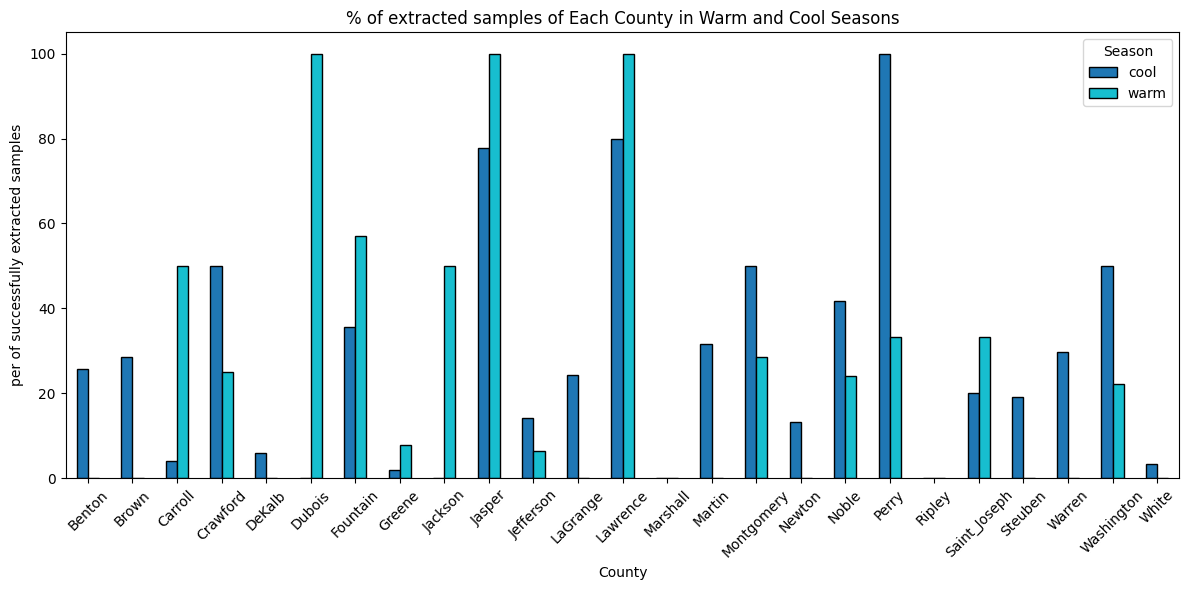

In [243]:


# Plotting
perc_success.plot(kind='bar', figsize=(12, 6), colormap='tab10', edgecolor='black')

plt.title('% of extracted samples of Each County in Warm and Cool Seasons')
plt.xlabel('County')
plt.ylabel('per of successfully extracted samples')
plt.xticks(rotation=45)
plt.legend(title='Season')
plt.tight_layout()

plt.show()


## Deciding based on the bar plot:

In [ ]:
# NO extraction has been done from 'warm' season in Benton, Brown, DeKalb, LaGrange, Martin, Newton, Steuben, Warren, White
# NO extraction has been done from 'cool' season in Dubois, Jackson,

In [249]:
combined_df[(combined_df['COUNTY'].isin(['Ripley','Marshall'])) & (combined_df['status'].isin(["unextracted"]))][['SCATID','Box','season','COUNTY']]

,SCATID,Box,season,COUNTY
489,9-10-42,12,warm,Marshall
625,4-5-51,1,warm,Ripley


In [284]:
to_extract_next = combined_df[combined_df['COUNTY'].isin(['Ripley','Martin','Benton','Brown','DeKalb','LaGrange','Martin',
                                        'Newton','Steuben','Warren','White'])][['SCATID','Box','COUNTY','season','status']].sort_values(by=['status','season','Box','COUNTY'], ascending=[False, False, True, True])

In [285]:
to_extract_next[(to_extract_next['Box'].isin([1,5])) & (to_extract_next['status'] != "successfully extracted")]

,SCATID,Box,COUNTY,season,status
77,4-11-1,1,Brown,warm,unextracted
78,4-11-101,1,Brown,warm,unextracted
79,4-11-102,1,Brown,warm,unextracted
80,4-11-103,1,Brown,warm,unextracted
83,4-22-174,1,Brown,warm,unextracted
84,4-22-182,1,Brown,warm,unextracted
90,4-9-61,1,Brown,warm,unextracted
91,4-9-69,1,Brown,warm,unextracted
92,4-9-70,1,Brown,warm,unextracted
93,4-9-71,1,Brown,warm,unextracted


# samples recommendation for next week: (Sep week1):

In [286]:
# decision to ask for extraction in next week:
for_next_week = ['4-5-51', '4-14-194', '3-8-169', '4-9-73', '3-14-171', '3-16-148', '3-16-149', '3-19-199']

In [287]:
def get_samples_info(sample_id):
    # Return the filtered DataFrame with specific columns
    return combined_df[combined_df['SCATID'] == sample_id][['Box', 'DATE', 'CONDITION', 'COUNTY', 'season']]

# Initialize an empty list to store the individual DataFrames
samples_info_list = []

# Loop through each sample ID in for_next_week and accumulate the results
for sample in for_next_week:
    samples_info_list.append(get_samples_info(sample))

# Concatenate the list of DataFrames into a single DataFrame
final_df = pd.concat(samples_info_list, ignore_index=True)

# Display the final DataFrame
print(final_df)


  Box       DATE              CONDITION  COUNTY season
0   1 2020-06-17    Severely desiccated  Ripley   warm
1   1 2020-08-05  Moderately desiccated  Martin   warm
2   1 2020-07-25  Moderately desiccated  Newton   warm
3   1 2020-07-07    Slightly desiccated   Brown   warm
4   1 2020-07-27    Severely desiccated  Warren   warm
5   5 2020-07-14    Severely desiccated  Benton   warm
6   5 2020-07-14    Severely desiccated  Benton   warm
7   5 2020-07-31    Severely desiccated  Newton   warm


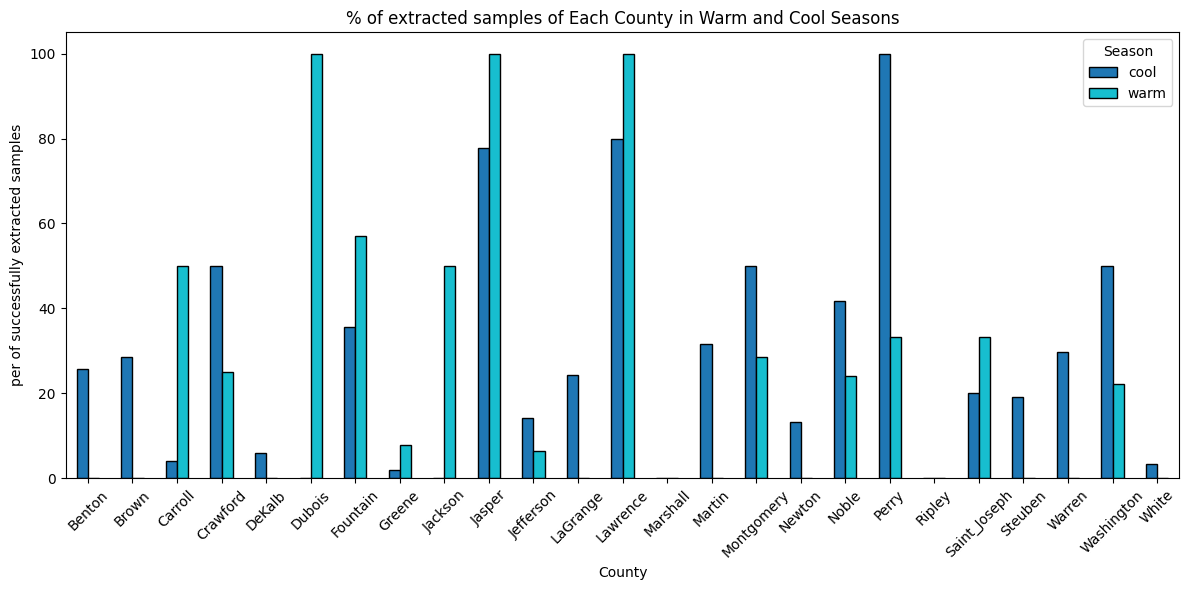

In [288]:
# Plotting
perc_success.plot(kind='bar', figsize=(12, 6), colormap='tab10', edgecolor='black')

plt.title('% of extracted samples of Each County in Warm and Cool Seasons')
plt.xlabel('County')
plt.ylabel('per of successfully extracted samples')
plt.xticks(rotation=45)
plt.legend(title='Season')
plt.tight_layout()

plt.show()
